# KMeans Clustering

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda, Inc.| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.13.1
Pandas Version: 0.20.3


In [18]:
import numpy as np
import pandas as pd

class kmeans:
    
    def __init__(self, k = 5, random_seed=None, iters=1000, n_init=10, init='kmeans++'):
        """
        Kmeans is a clustering algorithm which involves randomly initializing a set
        of clusters, assigning points by distance metric, then updating the means. 
        The algorithm terminates if movements stops or after "iters" iterations.
        ---
        Inputs: 
        k: the number of clusters to create
        random_seed: sets the random seed for reproducibility
        iters: how many iterations to attempt before breaking
        n_init: Initialize and run the algorithm this many times, keeping the
                best clusters, as decided by score.
        init: How to initialize the clusters. KMeans++ performs better, but takes more
              calculation. It weights the starting points based on distance from one anothers.
              Options: 'Random' (randomly select data points to act as seeds), 
                       'Kmeans++' (randomly select with distance squared weighting)
        """
        self._k = int(k)
        self._iters = iters
        self._n_init = n_init
        if init not in ['kmeans++','random']:
            print("Not a valid initialization, defaulting to kmeans++")
            init = 'kmeans++'
        self._init = init
        if random_seed:
            np.random.seed(random_seed)

    def compute_distance_to_cluster_mean(self, clst, pt):
        """
        Returns the distance to the cluster mean. Currently only uses Euclidean distance.
        ---
        Input: Cluster (cluster object), data point (np array)
        Output: Distance (float)
        """
        return np.sqrt(np.sum((clst.mean - pt)**2))

    def classify(self, pt):
        """
        Add a data point to the closest cluster.
        ---
        Input: data point (array)
        """
        cluster_num = self.get_clust_id(pt)
        self.clusters[cluster_num].add_member(pt)

    def get_clust_id(self,pt):
        """
        Given a point, return clusterid for cluster who's mean is the closest.
        ---
        Input: point (array)
        Output: cluster ID (int)
        """
        return min(range(self._k), key=lambda i: self.compute_distance_to_cluster_mean(self.clusters[i],pt))
    
    def init_clusters(self, X):
        """
        Select the initial starting points for the clusters. Two options: "random" which
        randomly draws starting points from the data AND "kmeans++" which randomly draws
        with distance based weighting. 
        ---
        Input: X (data, array)
        """
        self.clusters = [self.cluster() for _ in range(0,self._k)]
        
        if self._init == 'random':
            rand_points = np.copy(X)
            np.random.shuffle(rand_points)
            rand_points = rand_points.tolist()
            for c in self.clusters:
                c.mean = rand_points.pop()
        else: # default to kmeans++
            starting_points = [X[np.random.choice(np.arange(0,len(X)))]]
            
            for _ in range(self._k-1):
                dists = []
                datum = []
                for x in X:
                    if np.sum([np.array_equal(x,row) for row in starting_points]):
                        continue
                        
                    dist2 = 0.
                    for sp in starting_points:
                        dist2 += np.sum((x - sp)**2)
                    dists.append(dist2)
                    datum.append(x)
                dists = dists/np.sum(dists)
                starting_points.append(datum[np.random.choice(np.arange(0,len(datum)), p=dists)])
            for c, sp in zip(self.clusters, starting_points):
                c.mean = sp
        
        for p in X:
            self.classify(p)  

    def fit_predict(self,X):
        """
        Creates clusters for data X, and returns cluster ID's for each point.
        ---
        Input: X (data, array)
        Output: cluster IDs for X (array)
        """
        self.fit(X)
        return self.predict(X)
    
    def fit(self, X):
        """
        Initializes clusters, then moves the mean of the cluster to the center of
        all points in the cluster. Reassigns all points to their new 'nearest' cluster
        and repeats this process until no more assignments can occur (or too many iterations).
        Whole procedure is repeated n_init times, to overcome local minima. Only the best 
        clustering is kept as part of the model.
        ---
        Input: X (data, array/dataframe)
        """
        X = self.pandas_to_numpy(X)
        
        best_inertia = None
        best_clusters = []
        for _ in range(self._n_init):
            self.init_clusters(X)
            ischange = True
            i = 0
            while ischange and i < self._iters:
                ischange = False
                for c in self.clusters:
                    c.get_mean()
                    c.set_prev_members()
                    c.members = []

                for p in X:
                    self.classify(p)

                for c in self.clusters:
                    if c.is_changed():
                        ischange = True
                i += 1 
            current_inertia = 0.
            for c in self.clusters:
                c.get_mean()
                current_inertia += c.get_total_square_distance()
            
            if not best_inertia or current_inertia < best_inertia:
                best_clusters = self.clusters
                best_inertia = current_inertia
        
        self.clusters = best_clusters
        self.inertia = best_inertia
            
    def predict(self, X):
        """
        Given a point, the distance to each cluster center is calculated
        and the nearest cluster's ID is returned.
        ---
        Input: X (data, array/dataframe)
        """
        clust_ids = []
        for dt in self.pandas_to_numpy(X):
            clust_ids.append([self.get_clust_id(dt)])
        return np.array(clust_ids)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x)
    
    def score(self):
        """
        Inertia is a measure of the distance from each point to the cluster center,
        summed over all points and clusters. It's calculated during the fit 
        procedure.
        ---
        Output: inertia (float)
        """
        return self.inertia
        
    class cluster:
        def __init__(self):
            """
            This sub-class stores all the information related to each cluster.
            mean: where is the average location of points in this cluster
            members: which data points are in this cluster
            prev_members: which data points were in this cluster last optimization step
            """
            self.mean = None
            self.members = []
            self.prev_members = []

        def set_prev_members(self):
            """
            Transfers current_members to prev_members for later comparison
            """
            self.prev_members = self.members
            self.members = []

        def add_member(self,pt):
            """
            Helper function to add a point to this cluster.
            ---
            Input: data point (array)
            """
            self.members.append(pt)

        def is_changed(self):
            """ 
            Checks if this cluster has been modified by the most recent
            optimizatino step.
            ---
            Output:
            did cluster change (bool)
            """
            return not np.array_equal(self.members,self.prev_members)

        def get_mean(self):
            means = []
            for dim in np.array(self.members).T:
                means.append(np.mean(dim))
            self.mean = means
#             if not len(self.members):
#                 self.mean = [-999,-999]
#                 return
#             x,y = 0.,0.
#             for p in self.members:
#                 x+=p[0]
#                 y+=p[1]
#             self.mean = [x/len(self.members),y/len(self.members)]

        def get_total_square_distance(self):
            val = 0.
            for p in self.members:
                val += np.sqrt(np.sum((self.mean - p)**2))
            return val

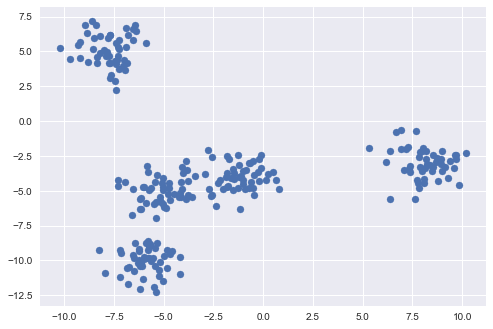

In [19]:
def get_data(n_clust = 3):
    X1 = np.random.normal(-5,1,50).reshape(-1,1)
    y1 = np.random.normal(-5,1,50).reshape(-1,1)
    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(-10,10),1,50).reshape(-1,1)
        y2 = np.random.normal(np.random.randint(-10,10),1,50).reshape(-1,1)
        X1 = np.vstack((X1,X2)).reshape(-1,1)
        y1 = np.vstack((y1,y2)).reshape(-1,1)
    X = np.hstack((X1,y1))
    return X

X = get_data(n_clust=5)
plt.scatter(X[:,0],X[:,1]);

In [20]:
km = kmeans(k=5)

In [21]:
km.fit(X)

In [22]:
for c in km.clusters:
    print(c.mean)

[8.1224495080891046, -3.0265316102039783]
[-1.1760327714351564, -4.0219355986616021]
[-5.126396421693606, -4.9946375478362537]
[-5.9012657664317612, -10.029226671486644]
[-7.7558157524624098, 5.0835101562862643]


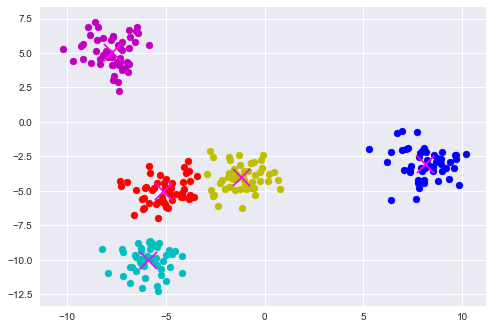

In [23]:
from itertools import cycle
colors = cycle('byrcmk')
preds = km.predict(X)
for cl in km.clusters:
    xplot, yplot = zip(*cl.members)
    col = next(colors)
    plt.scatter(xplot,yplot, c=col);
    plt.scatter(cl.mean[0],cl.mean[1],marker='x',s=300,c='magenta')

In [24]:
km.inertia

305.33865896103589

In [12]:
inertia = []
for k in range(1,21):
    km = kmeans(k=k, random_seed=42)
    km.fit(X)
    inertia.append(km.score())

In [13]:
inertia_rand = []
for k in range(1,21):
    km = kmeans(k=k, random_seed=42, init='random')
    km.fit(X)
    inertia_rand.append(km.score())

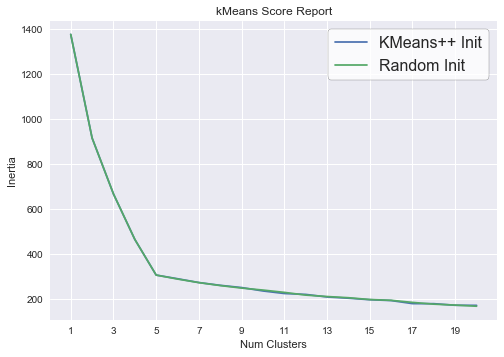

In [14]:
plt.plot(range(1,21),inertia, label='KMeans++ Init');
plt.plot(range(1,21),inertia_rand, label='Random Init');
plt.xlabel("Num Clusters")
plt.ylabel("Inertia")
plt.title("kMeans Score Report");
plt.xticks(np.arange(1,21,2));
plt.legend(loc='upper right', edgecolor="#333333", facecolor="#FFFFFF", fontsize=16, frameon=True);

Zoom in a bit on the range between 10 and 20 clusters to see if the randomizations are having an effect.

(100, 260)

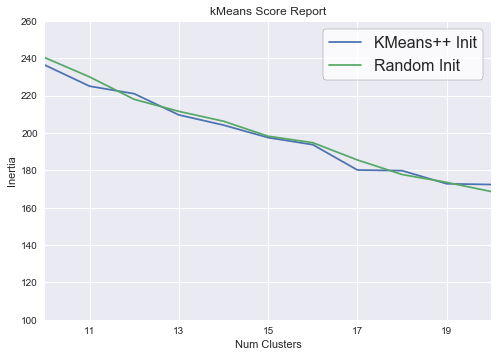

In [17]:
plt.plot(range(1,21),inertia, label='KMeans++ Init');
plt.plot(range(1,21),inertia_rand, label='Random Init');
plt.xlabel("Num Clusters")
plt.ylabel("Inertia")
plt.title("kMeans Score Report");
plt.xticks(np.arange(1,21,2));
plt.legend(loc='upper right', edgecolor="#333333", facecolor="#FFFFFF", fontsize=16, frameon=True);
plt.xlim(10,20);
plt.ylim(100,260)

## Test in 3D

In [49]:
def get_multidim_data(n_clust = 3, num_dim=3):
    X = np.random.normal(-5,1,size=(50,3))

    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(-10,10),1,size=(50,3))
        X = np.vstack((X,X2))
    return X

X = get_multidim_data(n_clust=5)

In [50]:
km = kmeans(k=5)
preds = km.fit_predict(X)

In [51]:
for c in km.clusters:
    print(c.mean)

[-8.0603799757718431, -8.0761220048577762, -7.8025371220419322]
[-0.89080936581879255, -0.79099358044855572, -1.1493570323484243]
[4.0297082072434902, 3.9079815265454072, 3.9213131452046679]
[-5.0863306653547413, -4.7415718946884793, -5.0927106020929909]
[8.0315160158219108, 7.687334524784875, 8.0460267932220901]


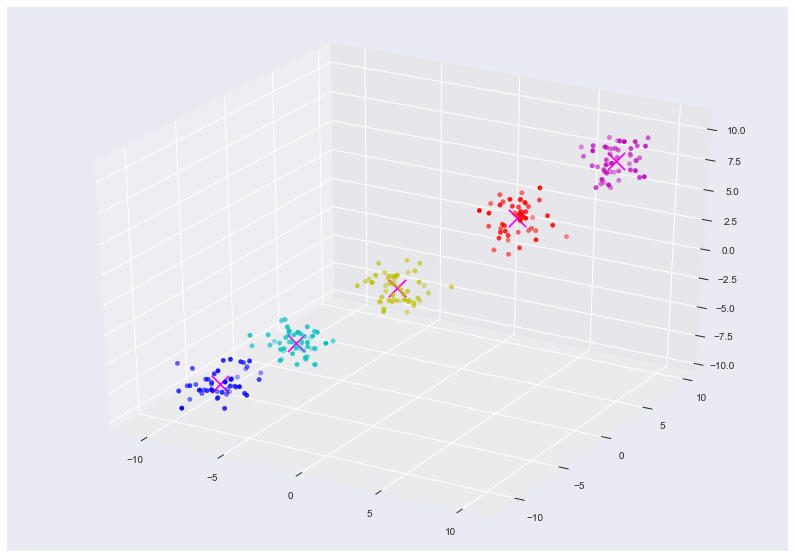

In [52]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
colors = cycle('byrcmk')
for cl in km.clusters:
    xplot, yplot, zplot = zip(*cl.members)
    col = next(colors)
    ax.scatter(xplot,yplot, zplot, c=col);
    ax.scatter(cl.mean[0],cl.mean[1], cl.mean[2],marker='x',s=300,c='magenta')